# Instalando o Kaggle

In [1]:
!pip install kaggle

# Realizando o upload do token de segurança de comunicação com o kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [3]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        153           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        290           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        855           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       5194           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      40917           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge      10743           False  
connectx

# Fazendo o download do dataset do kaggle

In [4]:
!kaggle datasets download -d saraivaufc/automatic-weather-stations-brazil

automatic-weather-stations-brazil.zip: Skipping, found more recently modified local copy (use --force to force download)


# Descompactando o dataset baixado

In [5]:
!unzip automatic-weather-stations-brazil.zip

Archive:  automatic-weather-stations-brazil.zip
replace automatic_stations_codes_2000_2021.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: automatic_stations_codes_2000_2021.csv  
replace automatic_weather_stations_inmet_brazil_2000_2021.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: automatic_weather_stations_inmet_brazil_2000_2021.csv  y
y



# Configurando o Spark

In [6]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop3.2.tgz
!tar xf spark-3.0.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

spark

In [8]:
# Criando uma sessão no Spark
spark = SparkSession.builder.getOrCreate()

from datetime import datetime, date  
from pyspark.sql import Row

Carregando dataset no spark

In [9]:
linhas = spark.sparkContext.textFile('automatic_weather_stations_inmet_brazil_2000_2021.csv')

In [10]:
df = linhas.map(lambda line:line.split(';'))

print(df)

#Colunas desejadas
def func(lista):
  return lista[0], lista[1], lista[2], lista[3], lista[4], lista[8], lista[16], lista[19]
 
df_limpo = df.map(func) 

PythonRDD[2] at RDD at PythonRDD.scala:53


In [11]:
df_limpo.take(2)


[('ESTACAO',
  'DATA (YYYY-MM-DD)',
  'HORA (UTC)',
  'PRECIPITACAO TOTAL HORARIO (mm)',
  'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
  'TEMPERATURA DO AR - BULBO SECO, HORARIA (C)',
  'UMIDADE RELATIVA DO AR, HORARIA (%)',
  'VENTO, VELOCIDADE HORARIA (m/s)'),
 ('A001', '2021-01-01', '0000', '0.0', '887.1', '20.9', '73.0', '0.8')]

In [12]:
#tentar otimizar filtro com isso aqui
filter = ['A306','A314','A315','A319','A324','A325','A332','A339','A342','A347','A358','A359','A360','A368','A369']

In [13]:
df_ceara = df_limpo.filter(lambda x: 'A306' in x or 'A314' in x or 'A315' in x or 'A319' in x or 'A324' in x or 'A325' in x or 'A332' in x or 'A339' in x or 'A342' in x or 'A347' in x or 'A358' in x or 'A359' in x or 'A360' in x or 'A368' in x or 'A369' in x).collect()

#df_ceara = df_ceara.map(lambda line:line.split('['))



In [14]:
len(df_ceara)

1579680

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DateType, FloatType, TimestampType

schema = StructType([
    StructField('ESTACAO', StringType(), True),
    StructField('DATA', DateType(), True),
    StructField('HORA', TimestampType(), True),
    StructField('PRECIPITACAO TOTAL HORARIO (mm)', IntegerType(), True),
    StructField('PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', FloatType(), True),
    StructField('TEMPERATURA DO AR - BULBO SECO, HORARIA (C)', FloatType(), True),
    StructField('UMIDADE RELATIVA DO AR, HORARIA (%)', FloatType(), True),
    StructField('VENTO, VELOCIDADE HORARIA (m/s)', FloatType(), True),
])

# Convert list to RDD
rdd = spark.sparkContext.parallelize(df_ceara)
df = spark.createDataFrame(rdd,['ESTACAO',
  'DATA',
  'HORA',
  'PRECIPITACAO',
  'PRESSAO_ATMOSFERICA',
  'TEMPERATURA',
  'UMIDADE',
  'VENTO'])

# Create data frame
#df = spark.createDataFrame(rdd,schema)
#print(df.schema)
df.show()

+-------+----------+----+------------+-------------------+-----------+-------+-----+
|ESTACAO|      DATA|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|
+-------+----------+----+------------+-------------------+-----------+-------+-----+
|   A306|2021-01-01|0000|         0.0|             1000.1|       27.7|   65.0|  3.4|
|   A306|2021-01-01|0100|         0.0|             1000.9|       27.0|   74.0|  0.6|
|   A306|2021-01-01|0200|         0.0|             1001.5|       26.3|   79.0|  0.0|
|   A306|2021-01-01|0300|         0.0|             1001.2|       26.1|   82.0|  0.0|
|   A306|2021-01-01|0400|         0.0|             1000.7|       26.0|   84.0|  0.3|
|   A306|2021-01-01|0500|         0.0|             1000.3|       25.6|   84.0|  0.0|
|   A306|2021-01-01|0600|         0.0|             1000.0|       25.1|   87.0|  0.0|
|   A306|2021-01-01|0700|         0.0|             1000.1|       24.8|   88.0|  0.0|
|   A306|2021-01-01|0800|         0.0|             1000.9|       

In [16]:
type(df)

pyspark.sql.dataframe.DataFrame

In [17]:
df.createOrReplaceTempView('tableA')
print(spark.sql('select * from tableA').show())

+-------+----------+----+------------+-------------------+-----------+-------+-----+
|ESTACAO|      DATA|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|
+-------+----------+----+------------+-------------------+-----------+-------+-----+
|   A306|2021-01-01|0000|         0.0|             1000.1|       27.7|   65.0|  3.4|
|   A306|2021-01-01|0100|         0.0|             1000.9|       27.0|   74.0|  0.6|
|   A306|2021-01-01|0200|         0.0|             1001.5|       26.3|   79.0|  0.0|
|   A306|2021-01-01|0300|         0.0|             1001.2|       26.1|   82.0|  0.0|
|   A306|2021-01-01|0400|         0.0|             1000.7|       26.0|   84.0|  0.3|
|   A306|2021-01-01|0500|         0.0|             1000.3|       25.6|   84.0|  0.0|
|   A306|2021-01-01|0600|         0.0|             1000.0|       25.1|   87.0|  0.0|
|   A306|2021-01-01|0700|         0.0|             1000.1|       24.8|   88.0|  0.0|
|   A306|2021-01-01|0800|         0.0|             1000.9|       

#Tratamento de Dados (ETL)

#### Tratamento de valores misssing/Verificando valores Missing

In [18]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+-------+----+----+------------+-------------------+-----------+-------+-----+
|ESTACAO|DATA|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|
+-------+----+----+------------+-------------------+-----------+-------+-----+
|      0|   0|   0|           0|                  0|          0|      0|    0|
+-------+----+----+------------+-------------------+-----------+-------+-----+



In [19]:
#Convertendo o data Frame typos
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DoubleType, LongType
dfC_plots = df.withColumn("ESTACAO",df.ESTACAO.cast(StringType())).withColumn("DATA",df.DATA.cast(LongType())).withColumn("HORA",df.HORA.cast(DoubleType())).withColumn("PRECIPITACAO",df.PRECIPITACAO.cast(DoubleType())).withColumn("PRESSAO_ATMOSFERICA",df.PRESSAO_ATMOSFERICA.cast(DoubleType())).withColumn("TEMPERATURA",df.TEMPERATURA.cast(DoubleType())).withColumn("UMIDADE",df.UMIDADE.cast(DoubleType())).withColumn("VENTO",df.VENTO.cast(DoubleType()))
dfC_plots = dfC_plots.drop('ESTACAO', 'DATA', 'HORA')
dfC_plots = dfC_plots.toPandas()

In [20]:
#Removação de valores nulls para plot
#Tratamento de dados para plot
dfC_plots.head()

,PRECIPITACAO,PRESSAO_ATMOSFERICA,TEMPERATURA,UMIDADE,VENTO
0,0.0,1000.1,27.7,65.0,3.4
1,0.0,1000.9,27.0,74.0,0.6
2,0.0,1001.5,26.3,79.0,0.0
3,0.0,1001.2,26.1,82.0,0.0
4,0.0,1000.7,26.0,84.0,0.3


In [21]:
#Drop de valores nulls
dfC_plots.dropna(inplace=True)
#Verificação de valores Nulus
dfC_plots.isnull().values.any()

False

Drop e verificação de valores missing se julgado necessário

df.na.drop()

df.describe().show()

In [22]:
df

DataFrame[ESTACAO: string, DATA: string, HORA: string, PRECIPITACAO: string, PRESSAO_ATMOSFERICA: string, TEMPERATURA: string, UMIDADE: string, VENTO: string]

In [23]:
#Convertendo o data Frame
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DateType, FloatType, TimestampType, LongType
dfNovo = df.withColumn("ESTACAO",df.ESTACAO.cast(StringType())).withColumn("DATA",df.DATA.cast(DateType())).withColumn("HORA",df.HORA.cast(IntegerType())).withColumn("PRECIPITACAO",df.PRECIPITACAO.cast(FloatType())).withColumn("PRESSAO_ATMOSFERICA",df.PRESSAO_ATMOSFERICA.cast(FloatType())).withColumn("TEMPERATURA",df.TEMPERATURA.cast(FloatType())).withColumn("UMIDADE",df.UMIDADE.cast(FloatType()))

In [24]:
dfNovo = dfNovo.withColumn("VENTO", df.VENTO.cast(FloatType()))

In [25]:
dfNovo

DataFrame[ESTACAO: string, DATA: date, HORA: int, PRECIPITACAO: float, PRESSAO_ATMOSFERICA: float, TEMPERATURA: float, UMIDADE: float, VENTO: float]

In [26]:
dfNovo.show()

+-------+----------+----+------------+-------------------+-----------+-------+-----+
|ESTACAO|      DATA|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|
+-------+----------+----+------------+-------------------+-----------+-------+-----+
|   A306|2021-01-01|   0|         0.0|             1000.1|       27.7|   65.0|  3.4|
|   A306|2021-01-01| 100|         0.0|             1000.9|       27.0|   74.0|  0.6|
|   A306|2021-01-01| 200|         0.0|             1001.5|       26.3|   79.0|  0.0|
|   A306|2021-01-01| 300|         0.0|             1001.2|       26.1|   82.0|  0.0|
|   A306|2021-01-01| 400|         0.0|             1000.7|       26.0|   84.0|  0.3|
|   A306|2021-01-01| 500|         0.0|             1000.3|       25.6|   84.0|  0.0|
|   A306|2021-01-01| 600|         0.0|             1000.0|       25.1|   87.0|  0.0|
|   A306|2021-01-01| 700|         0.0|             1000.1|       24.8|   88.0|  0.0|
|   A306|2021-01-01| 800|         0.0|             1000.9|       

# Analise Descritiva dos Dados (Data analysis)

#####Importando Bibliotecas: Data analysis

In [27]:
import numpy as np
import random as rnd
from pyspark.sql.window import Window
import pyspark.sql.functions as F


In [28]:
dfNovo.describe().show()

+-------+-------+-----------------+------------------+-------------------+------------------+------------------+------------------+
|summary|ESTACAO|             HORA|      PRECIPITACAO|PRESSAO_ATMOSFERICA|       TEMPERATURA|           UMIDADE|             VENTO|
+-------+-------+-----------------+------------------+-------------------+------------------+------------------+------------------+
|  count|1579680|          1579680|           1486216|            1499494|           1499843|           1488811|           1492437|
|   mean|   null|           1150.0|-926.1058227066236| 273.69593688815786|-627.0840773381889|-664.3884415147389|-667.8105625242465|
| stddev|   null|692.2188743441892|2898.8273853700452|  2695.637887685309|2475.6356963167495| 2609.132998897044| 2501.099204368778|
|    min|   A306|                0|           -9999.0|            -9999.0|           -9999.0|           -9999.0|           -9999.0|
|    max|   A369|             2300|              86.2|             1050.0|  

In [29]:
dfNovo.select('ESTACAO').describe().show()


+-------+-------+
|summary|ESTACAO|
+-------+-------+
|  count|1579680|
|   mean|   null|
| stddev|   null|
|    min|   A306|
|    max|   A369|
+-------+-------+



In [30]:
dfNovo.select('DATA').describe().show()


+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+



In [31]:
dfNovo.select('HORA').describe().show()


+-------+-----------------+
|summary|             HORA|
+-------+-----------------+
|  count|          1579680|
|   mean|           1150.0|
| stddev|692.2188743441892|
|    min|                0|
|    max|             2300|
+-------+-----------------+



In [32]:
dfNovo.select('PRECIPITACAO').describe().show()


+-------+------------------+
|summary|      PRECIPITACAO|
+-------+------------------+
|  count|           1486216|
|   mean|-926.1058227066236|
| stddev|2898.8273853700452|
|    min|           -9999.0|
|    max|              86.2|
+-------+------------------+



In [33]:
dfNovo.select('PRESSAO_ATMOSFERICA').describe().show()


+-------+-------------------+
|summary|PRESSAO_ATMOSFERICA|
+-------+-------------------+
|  count|            1499494|
|   mean| 273.69593688815786|
| stddev|  2695.637887685309|
|    min|            -9999.0|
|    max|             1050.0|
+-------+-------------------+



In [34]:
dfNovo.select('TEMPERATURA').describe().show()


+-------+------------------+
|summary|       TEMPERATURA|
+-------+------------------+
|  count|           1499843|
|   mean|-627.0840773381889|
| stddev|2475.6356963167495|
|    min|           -9999.0|
|    max|              44.8|
+-------+------------------+



In [35]:
dfNovo.select('UMIDADE').describe().show()


+-------+------------------+
|summary|           UMIDADE|
+-------+------------------+
|  count|           1488811|
|   mean|-664.3884415147389|
| stddev| 2609.132998897044|
|    min|           -9999.0|
|    max|             100.0|
+-------+------------------+



In [36]:
dfNovo.select('VENTO').describe().show()

+-------+------------------+
|summary|             VENTO|
+-------+------------------+
|  count|           1492437|
|   mean|-667.8105625242465|
| stddev| 2501.099204368778|
|    min|           -9999.0|
|    max|              13.2|
+-------+------------------+



In [37]:
float(dfNovo.describe("VENTO").filter("summary = 'max'").select("VENTO").collect()[0].asDict()['VENTO'])

13.2

######Percentil dos dados

######Percentis são medidas que dividem a amostra (por ordem crescente dos dados) em 100 partes, cada uma com uma percentagem de dados aproximadamente igual.O k-ésimo percentil Pk é o valor x (xk) que corresponde à frequência cumulativa de N .k/100, onde N é o tamanho amostral. Analise do percentil dos dados para ver o quão proximos estão as camadas de amostras


In [38]:
#Analise pela hora Hora
df_teste = df.select("ESTACAO","DATA","HORA", F.percent_rank().over(Window.partitionBy().orderBy(df['ESTACAO'])).alias("percent_rank"))
#df_teste.show()
#df_teste.show(10000)


In [39]:
#Analise pela hora Hora
df_teste = df.select("ESTACAO","DATA","HORA", F.percent_rank().over(Window.partitionBy().orderBy(df["DATA"])).alias("percent_rank"))
#df_teste.show(10000)

In [40]:
#Analise pela hora Hora
df_teste = df.select("ESTACAO","DATA","HORA", F.percent_rank().over(Window.partitionBy().orderBy(df["HORA"])).alias("percent_rank"))
#df_teste.show(10000)

In [41]:
#Analise pela hora "TEMPERATURA DO AR - BULBO SECO, HORARIA (C)"
df_teste = df.select("TEMPERATURA","UMIDADE","VENTO", F.percent_rank().over(Window.partitionBy().orderBy(df["TEMPERATURA"])).alias("percent_rank"))
#df_teste.show(10000)

In [42]:
#Analise pela hora "UMIDADE RELATIVA DO AR, HORARIA (%)"
df_teste = df.select("TEMPERATURA","UMIDADE","VENTO", F.percent_rank().over(Window.partitionBy().orderBy(df["UMIDADE"])).alias("percent_rank"))
#df_teste.show(10000)

In [43]:
#Analise pela hora Umidade Relativa
df_teste = df.select("TEMPERATURA","UMIDADE","VENTO", F.percent_rank().over(Window.partitionBy().orderBy(df["VENTO"])).alias("percent_rank"))
#df_teste.show(10000)

In [202]:
#Percentis são medidas que dividem a amostra (por ordem crescente dos dados) em 100 partes, cada uma com uma percentagem de dados aproximadamente igual.
#O k-ésimo percentil Pk é o valor x (xk) que corresponde à frequência cumulativa de N .k/100, onde N é o tamanho amostral. Analise do percentil dos dados 
#para ver o quão proximos estão as camadas de amostras
df_teste = df.select("ESTACAO","DATA","HORA", "PRECIPITACAO", "TEMPERATURA", "PRESSAO_ATMOSFERICA", "TEMPERATURA", "UMIDADE","VENTO", F.percent_rank().over(Window.partitionBy().orderBy(df["DATA"])).alias("percent_rank"))
df_teste.show(100)

+-------+----------+----+------------+-----------+-------------------+-----------+-------+-----+--------------------+
|ESTACAO|      DATA|HORA|PRECIPITACAO|TEMPERATURA|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|        percent_rank|
+-------+----------+----+------------+-----------+-------------------+-----------+-------+-----+--------------------+
|   A306|2003-02-12|   0|         0.0|       23.7|             1001.8|       23.7|   87.0|  2.3|                 0.0|
|   A306|2003-02-12| 100|         0.0|       23.7|             1002.0|       23.7|   87.0|  2.0|                 0.0|
|   A306|2003-02-12| 200|         0.0|       23.7|             1002.0|       23.7|   88.0|  1.2|                 0.0|
|   A306|2003-02-12| 300|         0.0|       23.9|             1001.6|       23.9|   88.0|  1.3|                 0.0|
|   A306|2003-02-12| 400|         0.0|       23.7|             1001.2|       23.7|   92.0|  1.8|                 0.0|
|   A306|2003-02-12| 500|         0.0|       23.7|      

# Data Analytics (Vizualição dos Dados)


Conversanto os tipos de dados

In [45]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Plotando gratico dos tipos de dados

In [46]:
dfNovo.show()

+-------+----------+----+------------+-------------------+-----------+-------+-----+
|ESTACAO|      DATA|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|
+-------+----------+----+------------+-------------------+-----------+-------+-----+
|   A306|2021-01-01|   0|         0.0|             1000.1|       27.7|   65.0|  3.4|
|   A306|2021-01-01| 100|         0.0|             1000.9|       27.0|   74.0|  0.6|
|   A306|2021-01-01| 200|         0.0|             1001.5|       26.3|   79.0|  0.0|
|   A306|2021-01-01| 300|         0.0|             1001.2|       26.1|   82.0|  0.0|
|   A306|2021-01-01| 400|         0.0|             1000.7|       26.0|   84.0|  0.3|
|   A306|2021-01-01| 500|         0.0|             1000.3|       25.6|   84.0|  0.0|
|   A306|2021-01-01| 600|         0.0|             1000.0|       25.1|   87.0|  0.0|
|   A306|2021-01-01| 700|         0.0|             1000.1|       24.8|   88.0|  0.0|
|   A306|2021-01-01| 800|         0.0|             1000.9|       

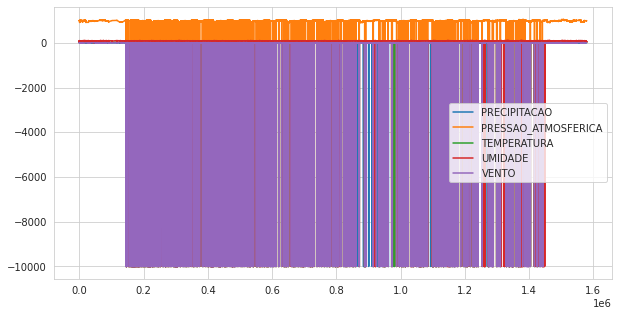

None

In [54]:
df_plots = dfNovo.toPandas()
dfC_plots.plot(figsize=(10,5))
display(plt.show())
#Certos dados não são registrados em determinados periodos
#Plot da distribuição dos dados

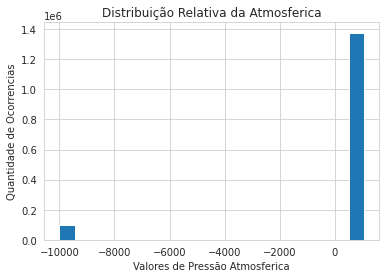

In [55]:
dfC_plots.PRESSAO_ATMOSFERICA.hist(bins = 20)
plt.xlabel("Valores de Pressão Atmosferica")
plt.ylabel("Quantidade de Ocorrencias")
plt.title("Distribuição Relativa da Atmosferica")
plt.show()

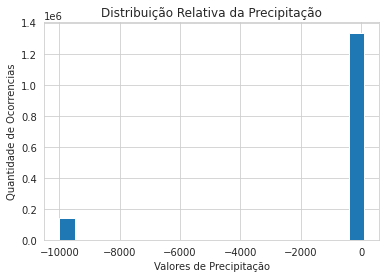

In [56]:
dfC_plots.PRECIPITACAO.hist(bins = 20)
plt.xlabel("Valores de Precipitação")
plt.ylabel("Quantidade de Ocorrencias")
plt.title("Distribuição Relativa da Precipitação")
plt.show()
#Concluimos que existe um grande periodo de precipitação no estado do ceara acompanhando de pequenas preciptitações após grande periodo de precipitação

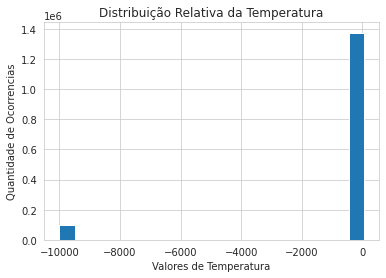

In [57]:
dfC_plots.TEMPERATURA.hist(bins = 20)
plt.xlabel("Valores de Temperatura")
plt.ylabel("Quantidade de Ocorrencias")
plt.title("Distribuição Relativa da Temperatura")
plt.show()

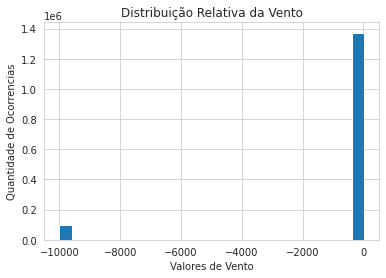

In [58]:
dfC_plots.VENTO.hist(bins = 25)
plt.xlabel("Valores de Vento")
plt.ylabel("Quantidade de Ocorrencias")
plt.title("Distribuição Relativa da Vento")
plt.show()

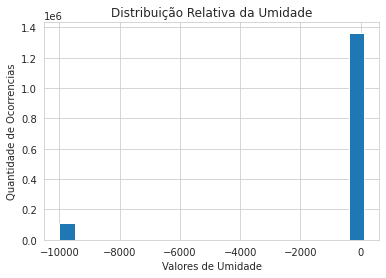

In [59]:
dfC_plots.UMIDADE.hist(bins = 20)
plt.xlabel("Valores de Umidade")
plt.ylabel("Quantidade de Ocorrencias")
plt.title("Distribuição Relativa da Umidade")
plt.show()

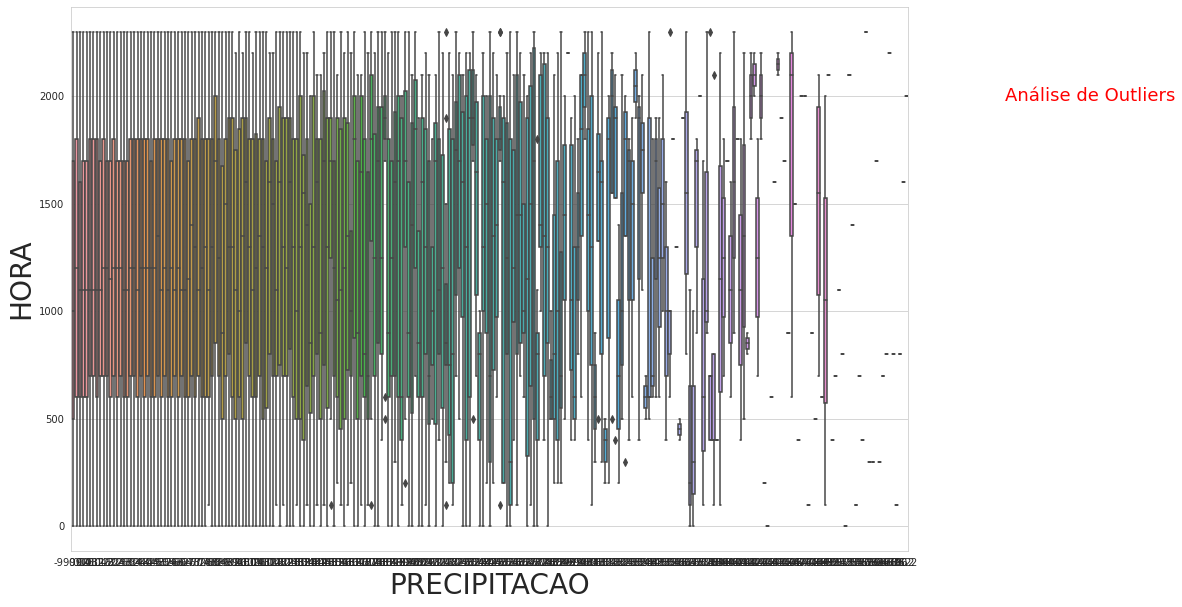

In [60]:
# Crie um Boxplot - Outliers PRECIPITACAO
# BoxPlot 
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x="PRECIPITACAO", y="HORA", data=df_plots)
ax.text(300.0,2000,"Análise de Outliers",fontsize=18,color="r",ha="center", va="center")
ax.xaxis.set_label_text("PRECIPITACAO",fontdict= {'size':28})
ax.yaxis.set_label_text("HORA",fontdict= {'size':28})
plt.show()

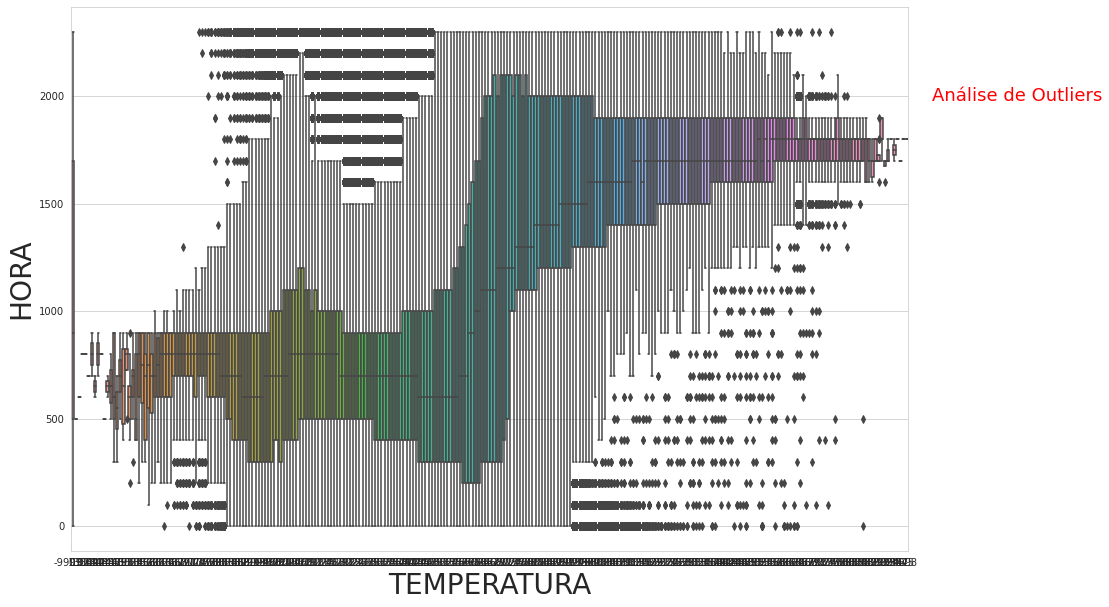

In [61]:
# Crie um Boxplot - Outliers PRECIPITACAO
# BoxPlot 
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x="TEMPERATURA", y="HORA", data=df_plots)
ax.text(300.0,2000,"Análise de Outliers",fontsize=18,color="r",ha="center", va="center")
ax.xaxis.set_label_text("TEMPERATURA",fontdict= {'size':28})
ax.yaxis.set_label_text("HORA",fontdict= {'size':28})
plt.show()

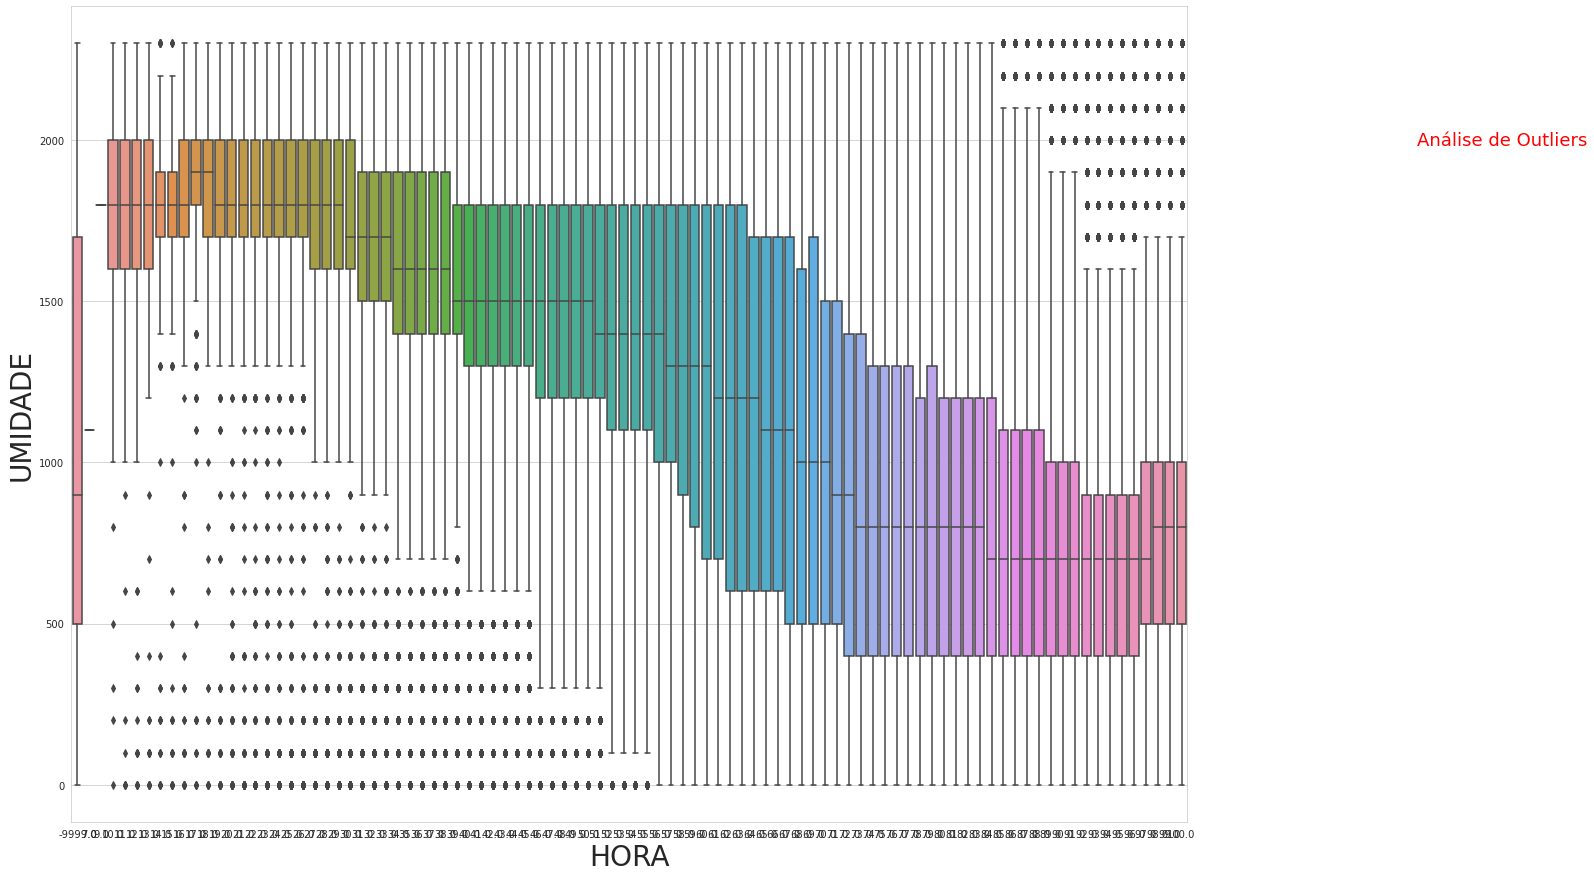

In [62]:
# Crie um Boxplot - Outliers VENTO
# BoxPlot 
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20,15))
sns.boxplot(x="UMIDADE", y="HORA", data=df_plots)
ax.text(120.0,2000,"Análise de Outliers",fontsize=18,color="r",ha="center", va="center")
ax.xaxis.set_label_text("HORA",fontdict= {'size':28})
ax.yaxis.set_label_text("UMIDADE",fontdict= {'size':28})
plt.show()

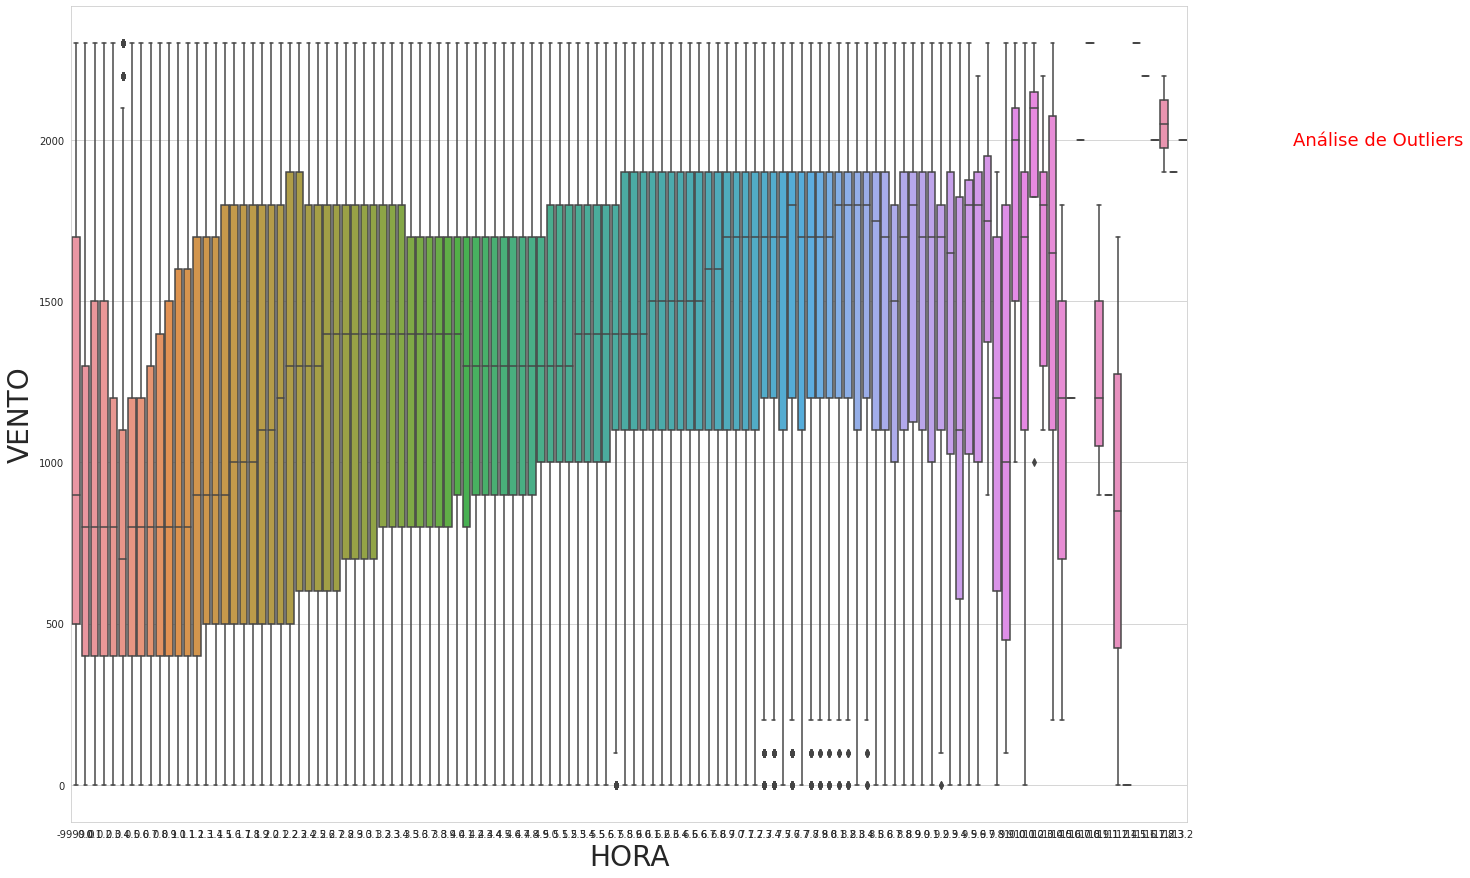

In [63]:
# Crie um Boxplot - Outliers VENTO
# BoxPlot 
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(20,15))
sns.boxplot(x="VENTO", y="HORA", data=df_plots)
ax.text(140.0,2000,"Análise de Outliers",fontsize=18,color="r",ha="center", va="center")
ax.xaxis.set_label_text("HORA",fontdict= {'size':28})
ax.yaxis.set_label_text("VENTO",fontdict= {'size':28})
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


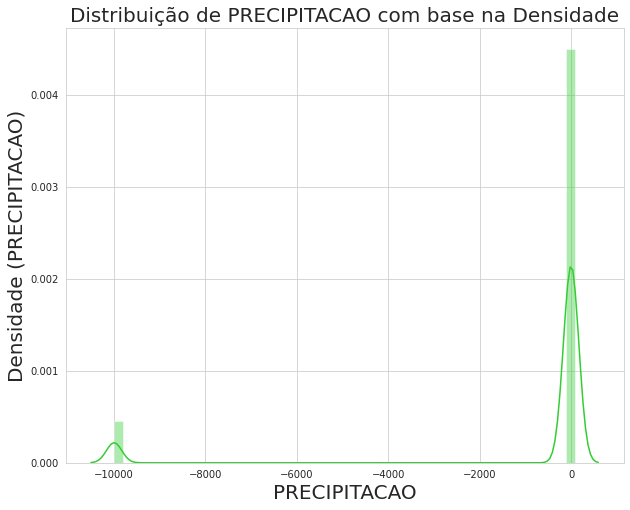

In [64]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_plots["PRECIPITACAO"], color="#33cc33",kde=True, ax=ax)
ax.set_title('Distribuição de PRECIPITACAO com base na Densidade', fontsize= 20)
plt.ylabel("Densidade (PRECIPITACAO)", fontsize= 20)
plt.xlabel("PRECIPITACAO", fontsize= 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


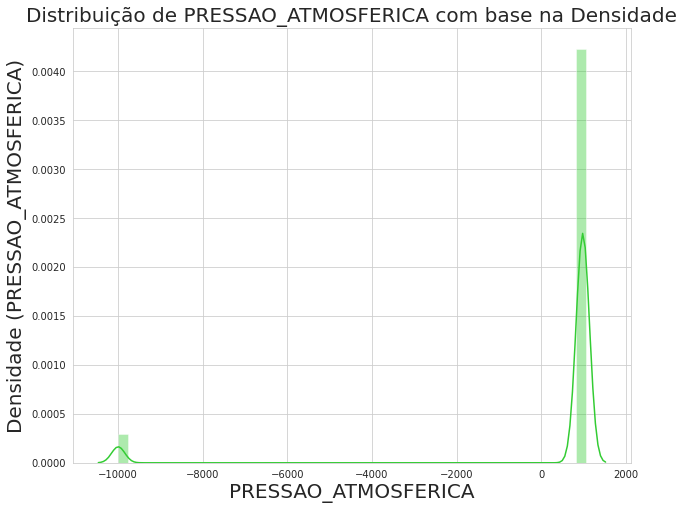

In [65]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_plots["PRESSAO_ATMOSFERICA"], color="#33cc33",kde=True, ax=ax)
ax.set_title('Distribuição de PRESSAO_ATMOSFERICA com base na Densidade', fontsize= 20)
plt.ylabel("Densidade (PRESSAO_ATMOSFERICA)", fontsize= 20)
plt.xlabel("PRESSAO_ATMOSFERICA", fontsize= 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


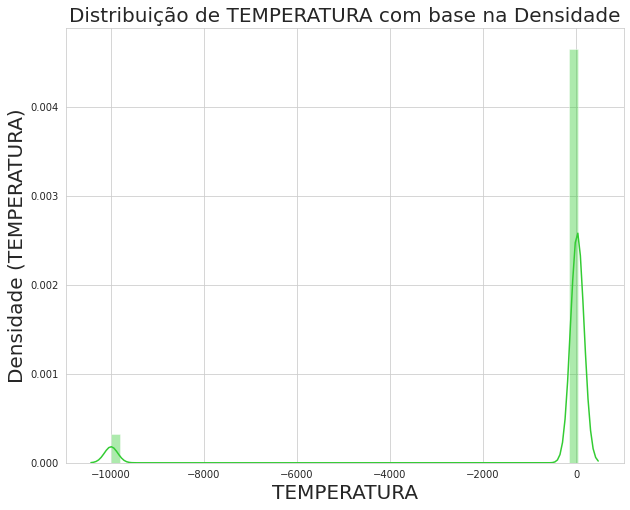

In [66]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_plots["TEMPERATURA"], color="#33cc33",kde=True, ax=ax)
ax.set_title('Distribuição de TEMPERATURA com base na Densidade', fontsize= 20)
plt.ylabel("Densidade (TEMPERATURA)", fontsize= 20)
plt.xlabel("TEMPERATURA", fontsize= 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


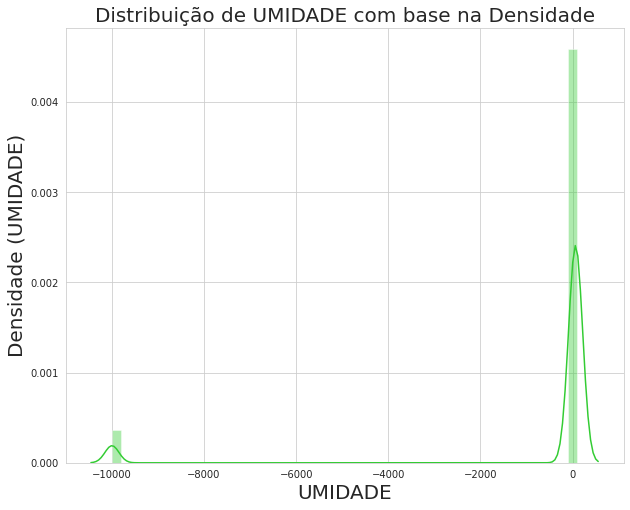

In [67]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_plots["UMIDADE"], color="#33cc33",kde=True, ax=ax)
ax.set_title('Distribuição de UMIDADE com base na Densidade', fontsize= 20)
plt.ylabel("Densidade (UMIDADE)", fontsize= 20)
plt.xlabel("UMIDADE", fontsize= 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


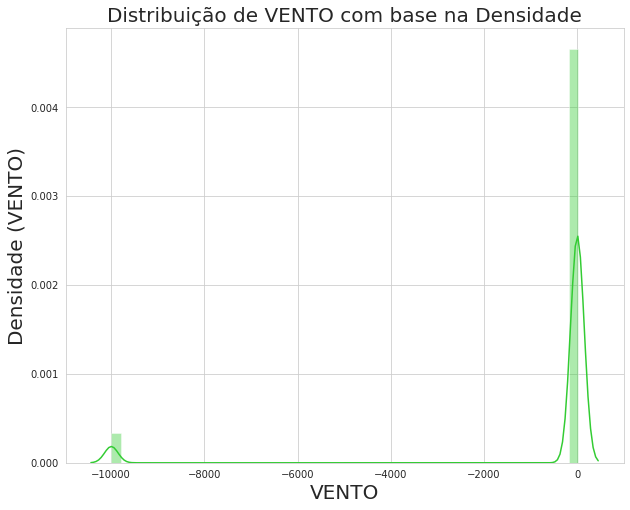

In [68]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_plots["VENTO"], color="#33cc33",kde=True, ax=ax)
ax.set_title('Distribuição de VENTO com base na Densidade', fontsize= 20)
plt.ylabel("Densidade (VENTO)", fontsize= 20)
plt.xlabel("VENTO", fontsize= 20)
plt.show()

In [69]:
def plot_corr(df, size=12):
    corr = df.corr()    
    fig, ax = plt.subplots(figsize = (size, size))
    ax.matshow(corr)  
    plt.xticks(range(len(corr.columns)), corr.columns) 
    plt.yticks(range(len(corr.columns)), corr.columns)

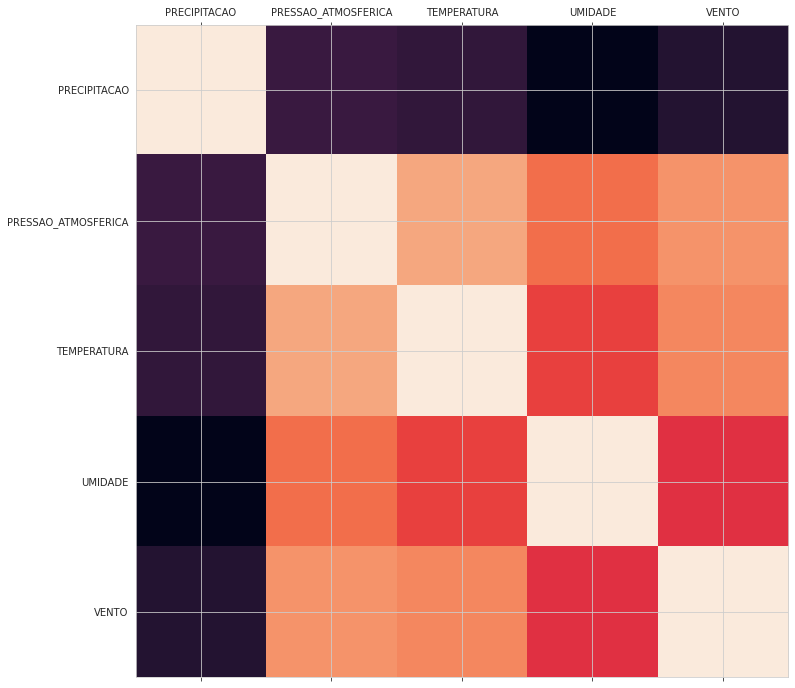

In [70]:
#print do grafico gerado
plot_corr(dfC_plots)

# ETL (Data Analytics): Processamento Pos-Aprendizado de Dados

#### Etapa de processamento de dados apos descoberta e analise dos dados, assim como limpeza, tratamento, analise de outliers, sujeira e valores negativos (Dados erroneos) 

In [97]:
#Convertendo o data Frame
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DateType, FloatType, TimestampType, LongType, DoubleType
dfCorrelacao = df.withColumn("ESTACAO",df.ESTACAO.cast(StringType())).withColumn("DATA",df.DATA.cast(LongType())).withColumn("HORA",df.HORA.cast(IntegerType())).withColumn("PRECIPITACAO",df.PRECIPITACAO.cast(FloatType())).withColumn("PRESSAO_ATMOSFERICA",df.PRESSAO_ATMOSFERICA.cast(FloatType())).withColumn("TEMPERATURA",df.TEMPERATURA.cast(FloatType())).withColumn("UMIDADE",df.UMIDADE.cast(FloatType())).withColumn("VENTO",df.VENTO.cast(FloatType()))
dfCorrelacao = dfCorrelacao.drop('ESTACAO', 'DATA')

In [98]:
dfCorrelacao

DataFrame[HORA: int, PRECIPITACAO: float, PRESSAO_ATMOSFERICA: float, TEMPERATURA: float, UMIDADE: float, VENTO: float]

In [99]:
dfCorrelacao.show()

+----+------------+-------------------+-----------+-------+-----+
|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|
+----+------------+-------------------+-----------+-------+-----+
|   0|         0.0|             1000.1|       27.7|   65.0|  3.4|
| 100|         0.0|             1000.9|       27.0|   74.0|  0.6|
| 200|         0.0|             1001.5|       26.3|   79.0|  0.0|
| 300|         0.0|             1001.2|       26.1|   82.0|  0.0|
| 400|         0.0|             1000.7|       26.0|   84.0|  0.3|
| 500|         0.0|             1000.3|       25.6|   84.0|  0.0|
| 600|         0.0|             1000.0|       25.1|   87.0|  0.0|
| 700|         0.0|             1000.1|       24.8|   88.0|  0.0|
| 800|         0.0|             1000.9|       24.4|   88.0|  0.0|
| 900|         0.0|             1001.5|       24.5|   89.0|  0.0|
|1000|         0.0|             1002.3|       25.2|   87.0|  0.0|
|1100|         0.2|             1002.5|       26.1|   83.0|  0.0|
|1200|    

In [100]:
#Convertendo o data Frame typos
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DoubleType
dfCorrelacao2 = df.withColumn("ESTACAO",df.ESTACAO.cast(StringType())).withColumn("DATA",df.DATA.cast(LongType())).withColumn("HORA",df.HORA.cast(DoubleType())).withColumn("PRECIPITACAO",df.PRECIPITACAO.cast(DoubleType())).withColumn("PRESSAO_ATMOSFERICA",df.PRESSAO_ATMOSFERICA.cast(DoubleType())).withColumn("TEMPERATURA",df.TEMPERATURA.cast(DoubleType())).withColumn("UMIDADE",df.UMIDADE.cast(DoubleType())).withColumn("VENTO",df.VENTO.cast(DoubleType()))
dfCorrelacao2 = dfCorrelacao2.drop('ESTACAO', 'DATA', 'HORA')
dfCorrelacao2 = dfCorrelacao2.toPandas()

In [101]:
dfCorrelacao2

,PRECIPITACAO,PRESSAO_ATMOSFERICA,TEMPERATURA,UMIDADE,VENTO
0,0.0,1000.1,27.7,65.0,3.4
1,0.0,1000.9,27.0,74.0,0.6
2,0.0,1001.5,26.3,79.0,0.0
3,0.0,1001.2,26.1,82.0,0.0
4,0.0,1000.7,26.0,84.0,0.3
...,...,...,...,...,...
1579675,NaN,NaN,NaN,NaN,NaN
1579676,NaN,NaN,NaN,NaN,NaN
1579677,NaN,NaN,NaN,NaN,NaN
1579678,NaN,NaN,NaN,NaN,NaN


##Vetor de Densidade

##### Um DenseVector é a implementação "óbvia" de um Vector, com uma variações.Os dados subjacentes podem ter mais dados do que o Vetor, representados o deslocamento na matriz (apatir do 0º elemento), e cada passo mostra a distância dos elementos um do outro.

In [103]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
  inputCols = ['HORA', 'PRECIPITACAO', 'PRESSAO_ATMOSFERICA', 'TEMPERATURA', 'UMIDADE', 'VENTO']
  , outputCol = "Dense Vector"
)

In [104]:
output = assembler.transform(dfCorrelacao)

In [105]:
output.show()

+----+------------+-------------------+-----------+-------+-----+--------------------+
|HORA|PRECIPITACAO|PRESSAO_ATMOSFERICA|TEMPERATURA|UMIDADE|VENTO|        Dense Vector|
+----+------------+-------------------+-----------+-------+-----+--------------------+
|   0|         0.0|             1000.1|       27.7|   65.0|  3.4|[0.0,0.0,1000.099...|
| 100|         0.0|             1000.9|       27.0|   74.0|  0.6|[100.0,0.0,1000.9...|
| 200|         0.0|             1001.5|       26.3|   79.0|  0.0|[200.0,0.0,1001.5...|
| 300|         0.0|             1001.2|       26.1|   82.0|  0.0|[300.0,0.0,1001.2...|
| 400|         0.0|             1000.7|       26.0|   84.0|  0.3|[400.0,0.0,1000.7...|
| 500|         0.0|             1000.3|       25.6|   84.0|  0.0|[500.0,0.0,1000.2...|
| 600|         0.0|             1000.0|       25.1|   87.0|  0.0|[600.0,0.0,1000.0...|
| 700|         0.0|             1000.1|       24.8|   88.0|  0.0|[700.0,0.0,1000.0...|
| 800|         0.0|             1000.9|    

In [106]:
#PROCESSAMENTO E TRATAMENTO DE DADOS FINAIS PARA MACHINE LEARNING (TRATAMENTO REALIZADO APOS DESCOBERTA DE DADOS MAIS PROFUNDA)
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, DateType, FloatType, TimestampType, LongType, DoubleType

dfNovo = df.withColumn("ESTACAO",df.ESTACAO.cast(StringType())).withColumn("DATA",df.DATA.cast(DateType())).withColumn("HORA",df.HORA.cast(IntegerType())).withColumn("PRECIPITACAO",df.PRECIPITACAO.cast(DoubleType())).withColumn("PRESSAO_ATMOSFERICA",df.PRESSAO_ATMOSFERICA.cast(DoubleType())).withColumn("TEMPERATURA",df.TEMPERATURA.cast(DoubleType())).withColumn("UMIDADE",df.UMIDADE.cast(DoubleType()))
dfNovo = dfNovo.withColumn("VENTO", df.VENTO.cast(FloatType()))
dfNovo = dfNovo.na.drop()

#TRATAMENTO DOS VALORES -99999
lista = dfNovo.filter((dfNovo.PRECIPITACAO  > 0) &  (dfNovo.PRESSAO_ATMOSFERICA  > 0)  &  (dfNovo.TEMPERATURA  > 0)  &  (dfNovo.UMIDADE  > 0)  &  (dfNovo.VENTO  > 0)).collect()
rdd_filtrado = spark.sparkContext.parallelize(lista)
 

assembler = VectorAssembler(
  inputCols = ['PRECIPITACAO', 'PRESSAO_ATMOSFERICA', 'TEMPERATURA', 'UMIDADE', 'VENTO']
  , outputCol = "features"
)
 
df_filtrado = spark.createDataFrame(rdd_filtrado,['ESTACAO',
  'DATA',
  'HORA',
  'PRECIPITACAO',
  'PRESSAO_ATMOSFERICA',
  'TEMPERATURA',
  'UMIDADE',
  'VENTO'])

assembled = assembler.transform(df_filtrado)

##Correlação das variaveis

#####Os coeficientes de correlação são usados para medir as relações entre variáveis, representando o entendimento da forma que as variaveis se comportam em em relação as outras, permitindo assim na analise ser identificada as relações entre a variabilidade de ambas.

In [107]:
dfCorrelacao2.corr()

,PRECIPITACAO,PRESSAO_ATMOSFERICA,TEMPERATURA,UMIDADE,VENTO
PRECIPITACAO,1.000000,0.794169,0.788786,0.756376,0.779569
PRESSAO_ATMOSFERICA,0.794169,1.000000,0.957413,0.926092,0.946120
TEMPERATURA,0.788786,0.957413,1.000000,0.903554,0.939644
UMIDADE,0.756376,0.926092,0.903554,1.000000,0.894423
VENTO,0.779569,0.946120,0.939644,0.894423,1.000000


# Importando bibliotecas de Machine Learning

###### Importando bibliotecas de machine learning: Bibliotecas Sklearn



In [108]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import sklearn 
print (sklearn.__version__)
import numpy as np
from sklearn.impute import SimpleImputer

0.22.2.post1


#### Apos a separação dos dados de treino e teste para o modelo. 
- Criação dos dados de treino e teste  do modelo

## Machine Learning Clusterização usando KMeans

######IMPORTANDO BIBLIOTECA

In [187]:
#IMPORTANDO BIBLIOTECAS
from pyspark.sql.functions import lit  
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

##### Incializando modelo, treinando e realizando predição

In [188]:
#CLUSTERING#
kmeans = KMeans(k=2, seed=666)  # 2 clusters
model = kmeans.fit(assembled.select('features'))
result = model.transform(assembled)
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
score=evaluator.evaluate(result)
silhouette_score.append(score)

In [189]:
#PRINT DO SCORE DA SILHUETA
print("Silhouette Score:",score)

Silhouette Score: 0.8423311490205222


###Melhor Simulheta/ Quantidade de Clusters

##### Calcular o Indice 'n' clusteres

In [190]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
# Importando os arquivos
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Importando os arquivos
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [191]:
pdf2 = result.toPandas()
pdf2.drop(['ESTACAO'],axis=1,inplace=True)
pdf2.drop(['DATA'],axis=1,inplace=True)
pdf2.drop(['HORA'],axis=1,inplace=True)
pdf2.head()

,PRECIPITACAO,PRESSAO_ATMOSFERICA,TEMPERATURA,UMIDADE,VENTO,features,prediction
0,0.8,1000.2,24.2,96.0,1.0,"[0.8, 1000.2, 24.2, 96.0, 1.0]",0
1,0.6,999.3,27.8,74.0,0.4,"[0.6, 999.3, 27.8, 74.0, 0.4000000059604645]",0
2,0.4,996.9,30.7,52.0,3.1,"[0.4, 996.9, 30.7, 52.0, 3.0999999046325684]",0
3,0.6,996.8,32.1,48.0,0.1,"[0.6, 996.8, 32.1, 48.0, 0.10000000149011612]",0
4,0.6,997.1,30.9,48.0,4.4,"[0.6, 997.1, 30.9, 48.0, 4.400000095367432]",0


In [192]:
# Definindo a quantidade de clusters
# Depois de varias analises de processamento de dados o numero de clusters escolhidos será 2
# definição do objeto
kmeans = KMeans(n_clusters=2)

In [193]:
#transferindo os dados para variavel a ser lida no modelo do kmeans
Kfit = pdf2.iloc[:, 0:4].values

In [194]:
kmeans.fit(Kfit)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [195]:
preds = kmeans.predict(Kfit)
silhouette_score(Kfit,preds)

0.6773522798663629

In [196]:
for k in range(2, 5):
    kmeans_ = KMeans(n_clusters=k, random_state=10)
    kmeans_.fit(Kfit)
    print(k, silhouette_score(Kfit, kmeans_.predict(Kfit)))

2 0.6773522798663629
3 0.5570206866356615
4 0.5526003544017374


In [198]:
def plot_silhouettes(algorithm, num_k, ax):
  visualizer = SilhouetteVisualizer(algorithm, colors='yellowbrick', ax=ax, title="Silhueta com K="+str(num_k))
  visualizer.fit(X_blobs)
  visualizer.ax.set_xlabel("Coeficientes de Silhueta")
  visualizer.ax.set_ylabel("Clusters")


In [200]:
#plot_silhouettes(kmeans, k, axs[round(k/3)-1][(k-2) % 3])]

#Vizualição dos dados 

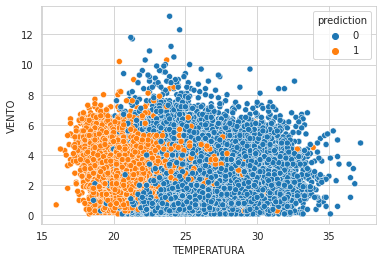

In [197]:
import seaborn as sns

pdf = result.toPandas()
sns.scatterplot(data=pdf, x='TEMPERATURA', y='VENTO', hue='prediction')